# Fourth Assignment - FINTECH 540 - Machine Learning for FinTech - Dimensionality Reduction with Autoencoders

In this assignment, you will attempt to replicate the S&P 500 index using the price series of some of its constituents. This task involves applying machine learning techniques, specifically neural networks, to select a subset of companies that tracks the index value well. You may also explore using a Principal Component Analysis (PCA) as a benchmarking tool, though this is not mandatory. The primary objective of this task is to achieve a satisfactory performance on the test set (out-of-sample). For a reference on the meaning of this exercise, refer to notebook 14 of our class material.

## Dataset Overview

- **Asset Close Prices**: 360 stocks + S&P500 Index (Last column of both files) from 2000 to 2023.
- **Format**: Divided into train and test sets (2 files are provided). Do not split again into train and test. Split only the train set if you want to obtain a validation set for hyperparameter selection.


## Task and General Hints

In this assignment, you are tasked with building an unsupervised learning model on equity data. Your primary goal is to ensure accurate out-of-sample reproduction of the given index (S&P500) through a subset of the constituents and evaluate them with the below-mentioned metric.

To guide you through this process, consider breaking down your tasks into the following three phases:

**Preprocessing**
The dataset is already free of inconsistencies, missing values, or outliers. 
- **Data Splitting**: The dataset is partitioned, and two files are provided to you.

**Model Selection**
- This notebook focuses on using neural networks for index replication. You can experiment with the different neural network architectures (autoencoders) we have seen in class. Feel free to compare the performance against a PCA methodology. 

**Model Tuning and Evaluation**
- Once you've selected a model, you'll want to fine-tune its parameters to achieve a good index tracking out-of-sample. You must also choose the number of companies used to reproduce the index dynamics.
- You may adjust parameters manually or construct a routine to fit several models with different hyperparameters. 
- Evaluate your final model using the function provided at the end of the notebook, paying attention to respect the indicated naming convention.

**Note**: Parameter choices and tuning should be made thoughtfully while it is up to you. Carefully study the documentation of the neural network models and refer to the Jupyer Notebooks we used in class to see the possible parameters you can fine-tune.

**IMPORTANT REMARK**: 
You must use the test set solely as data the model has never seen before. The results on that part of the dataset are those that are going to provide your grade.

Remember to set the seed when training and instantiating your model. You can use either Keras (Tensorflow) or Pytorch for this task, and you must make your results fully reproducible for grading. Double-check that you have correctly set the seed before diving into the coding part.

- [Setting the seed in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed)
- [Setting the seed in Pytorch](https://pytorch.org/docs/stable/notes/randomness.html)

# Grading Rubric

Your grade for this assignment will be determined by a composite score that considers both the **normalized Root Mean Squared Error (RMSE)** on the test set and the **efficiency of your index reconstruction**. The formula for your final grade is as follows:

$$ \text{Final Score} = \text{Weighted RMSE Score} + \text{Weighted Efficiency Score} $$

This will be a number between 0 and 100, with grades potentially curved before release.

**Components of the Grading Rubric**

1. **RMSE Score:**
   - Calculated as:
     $$ \text{Normalized RMSE} = 1 - \left( \frac{\text{RMSE}}{\text{MAX_POSSIBLE_RMSE}} \right) $$
   - `MAX_POSSIBLE_RMSE` is set as the standard deviation of the target variable.
   - RMSE measures how close your constructed index is to the actual index.
   - This component contributes 70% to your final score.

2. **Efficiency Score:**
   - Calculated as:
     $$ \text{Efficiency Score} = 1 - \left( \frac{\text{Number of Companies Used}}{\text{Total Number of Companies}} \right) $$
   - Encourages models that use fewer companies for index replication. The more companies you use, the more costly it would be to construct that portfolio to track the S&P500, so the less, the better.
   - This component contributes 30% to your final score.

The final score is a weighted sum of the RMSE and Efficiency scores:

$$ \text{Final Score} = (\text{Weight RMSE} \times \text{Normalized RMSE}) + (\text{Weight Efficiency} \times \text{Efficiency Score}) $$

Where:
- `Weight RMSE` = 0.7 
- `Weight Efficiency` = 0.3

The final grade will be:

$$ \text{Grade} = \lceil \text{Final Score} \times 100 \rceil $$

Rounded up to the nearest whole number.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
# from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation, Input
import os
import random
# Set the random seed for reproducibility
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Example: Set the seed
set_seed(42)

load_data = True

In [8]:
import numpy as np
import math

def evaluate_index_performance(y_test, y_pred, num_companies_used, total_companies=360, weight_rmse=0.7, weight_efficiency=0.3):
    """
    Function to evaluate the performance of the reconstructed index.
    
    :param y_test: Actual index values (out of sample)
    :param y_pred: Predicted index values using a subset of companies
    :param num_companies_used: Number of companies used for the reconstruction
    :param total_companies: Total number of companies in the index (default 500 for S&P 500)
    :param weight_mse: Weight for the MSE score (default 0.7)
    :param weight_efficiency: Weight for the efficiency score (default 0.3)
    :return: A composite score combining MSE and efficiency
    """
    # Calculate MSE and normalized MSE score
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    max_possible_rmse = y_test.std()
    rmse_score = 1 - rmse / max_possible_rmse

    # Calculate efficiency score
    efficiency_score = 1 - (num_companies_used / total_companies)

    # Calculate final grade
    final_score = weight_rmse * rmse_score + weight_efficiency * efficiency_score

    return final_score

In [9]:
#read data
train_df = pd.read_csv('sp_train.csv')
test_df = pd.read_csv('sp_test.csv')
assets_names = train_df.iloc[:,1:-1].columns
index_train = train_df['S&P']
X_train = train_df[assets_names]
index_test = test_df['S&P']
X_test = test_df[assets_names]


In [10]:
# Normalize data
scaler = MinMaxScaler((0, 1))
# Stocks data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Index data
scaler_index = MinMaxScaler((0, 1))
index_train = scaler_index.fit_transform(index_train.values.reshape(-1, 1))
index_test = scaler_index.transform(index_test.values.reshape(-1, 1))


In [ ]:
def fine_tuning(X_train,X_test, index_test, batch_size, n_stocks ):
    ## Deep Autoencoder - Tensorflow
    
    # Network hyperparameters
    n_inputs = X_train.shape[1]
    
    # Training hyperparameters
    epochs = 200
    batch_size = batch_size
    

    # Define model
    input_layer = Input(shape=(n_inputs,)) # input
    # Encoder Layers
    encoded = Dense(512, activation='relu',activity_regularizer=tf.keras.regularizers.l2(10e-7))(input_layer)  # First encoder layer with ReLU activation
    encoded = Dense(256, activation='relu')(encoded)     # Second encoder layer with linear activation
    encoded = Dense(128, activation='relu')(encoded) # code
    # Decoder Layers
    decoded = Dense(256, activation='relu')(encoded)       # First decoder layer with ReLU activation
    decoded = Dense(512, activation='relu')(decoded)       # Second decoder layer with ReLU activation

    decoded = Dense(n_inputs, activation='linear')(decoded) 

    # Autoencoder
    model = Model(input_layer, decoded)
    
    # Compile autoencoder
    model.compile(loss='mse', optimizer='adam')
    # Fit the model
    history = model.fit(X_train,
                        X_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        verbose=0
                        )
    
    """
    # Visualize training loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    #plt.savefig('images/vanillaAE_loss.png', bbox_inches='tight')
    """
    
    
    # Obtain reconstruction of the stocks
    X_train_pred = model.predict(X_train)
    X_test_pred = model.predict(X_test)
    
    
    

    
    # Obtain reconstruction of the stocks
    X_train_pred = model.predict(X_train)
    X_test_pred = model.predict(X_test)

    error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
    #print('Training MSE: %.8f' %np.mean(error))

    error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
    #print('Testing MSE: %.8f' %np.mean(error_test))
    
    
    # Sort stocks by reconstruction error
    ind = np.argsort(error)
    sort_error = error[ind]
    sort_assets_names = assets_names[ind]
    
    
    
    # Identify stocks
    n = n_stocks

    portfolio_train = X_train_pred[:, ind[:n]]
    portfolio_test = X_test_pred[:, ind[:n]]

    # Create portfolio in-sample
    tracked_index_insample = np.mean(portfolio_train, axis=1)

    # Create portfolio out-sample
    tracked_index_outofsample = np.mean(portfolio_test, axis=1)
    
    index_test = index_test.squeeze()# to facilitate evaluation

    grade = evaluate_index_performance(index_test, tracked_index_outofsample, n)
    
    """
    # In-sample
    plt.figure()
    plt.plot(index_train, label='Index')
    plt.plot(tracked_index_insample, label='Tracked Index')
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Normalized price')
    """
    
    # Plot tracked index (out-of-sample)
    plt.figure()
    plt.plot(index_test, label='Index')
    plt.plot(tracked_index_outofsample, label='Tracked Index')
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Normalized price')
    plt.show()
    #plt.savefig('images/vanillaAE_outofsample.png', bbox_inches='tight')
    
    
    return grade, index_test,tracked_index_outofsample





37/37 [==============================] - 0s 1ms/step


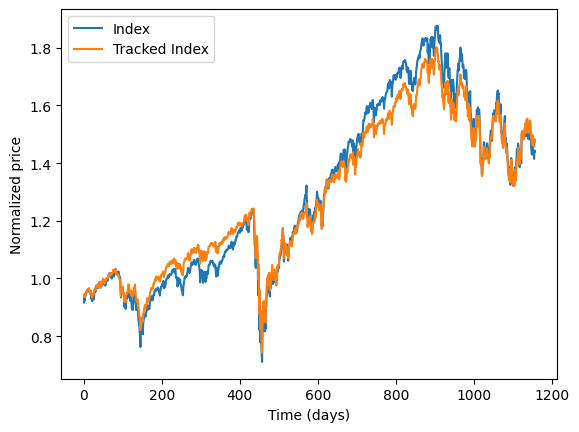

The grade for this assignment is 89.00, The number of stocks is 1
37/37 [==============================] - 0s 1ms/step


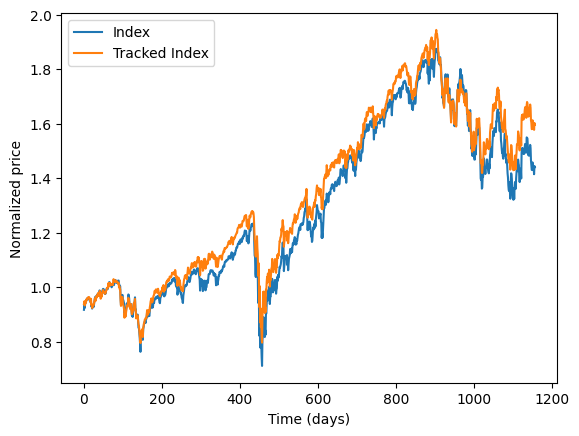

The grade for this assignment is 86.00, The number of stocks is 2
37/37 [==============================] - 0s 1ms/step


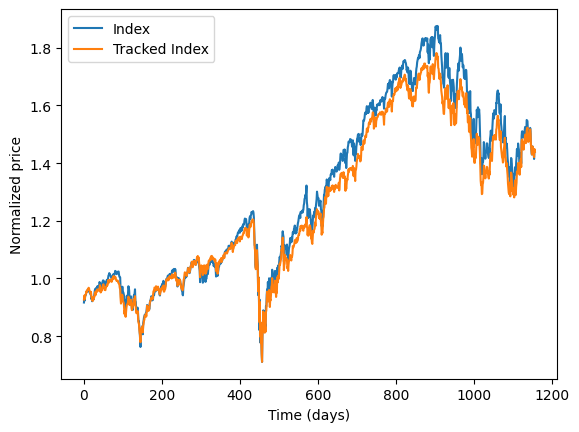

The grade for this assignment is 88.00, The number of stocks is 3
37/37 [==============================] - 0s 1ms/step


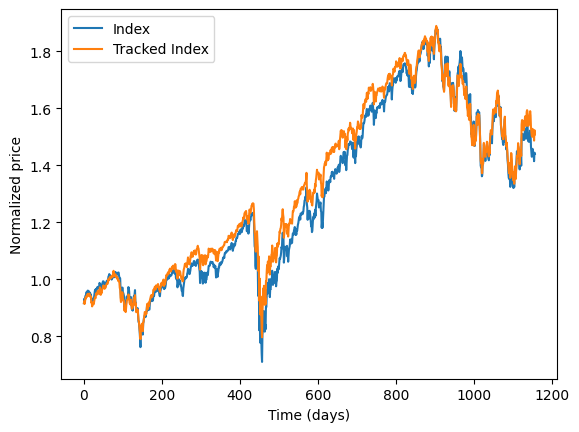

The grade for this assignment is 89.00, The number of stocks is 4
37/37 [==============================] - 0s 2ms/step


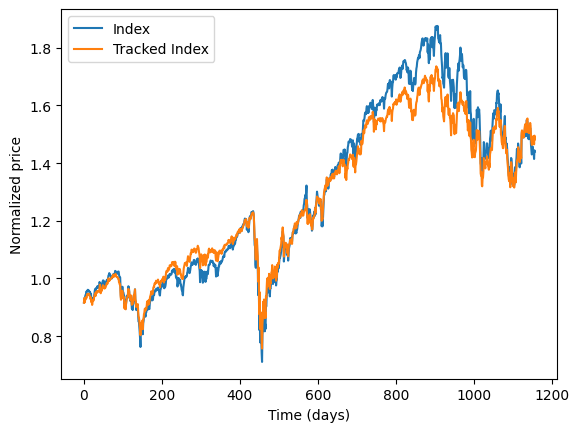

The grade for this assignment is 86.00, The number of stocks is 5
37/37 [==============================] - 0s 1ms/step


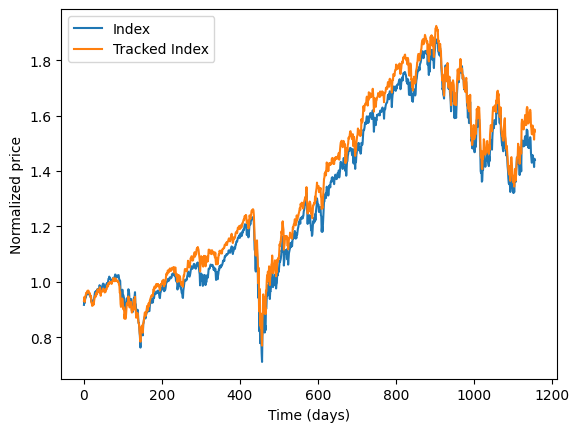

The grade for this assignment is 89.00, The number of stocks is 6
37/37 [==============================] - 0s 1ms/step


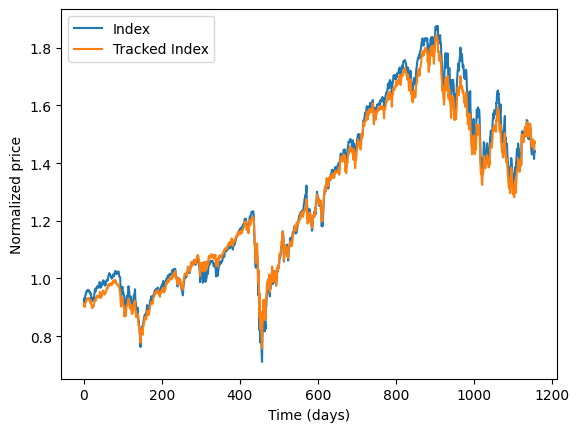

The grade for this assignment is 92.00, The number of stocks is 7
37/37 [==============================] - 0s 1ms/step


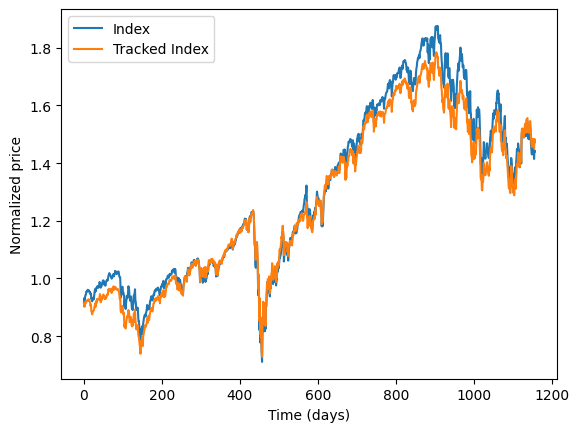

The grade for this assignment is 88.00, The number of stocks is 8
37/37 [==============================] - 0s 965us/step


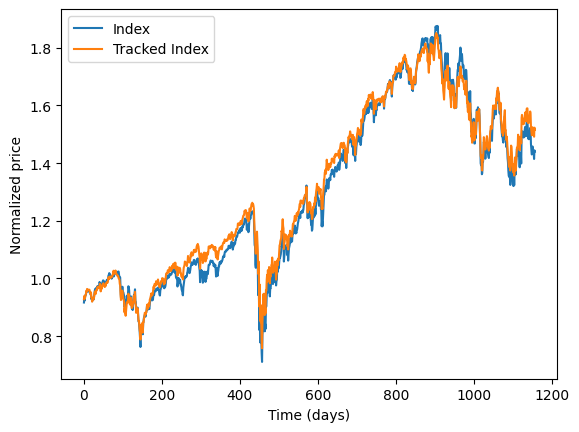

The grade for this assignment is 92.00, The number of stocks is 9
37/37 [==============================] - 0s 1ms/step


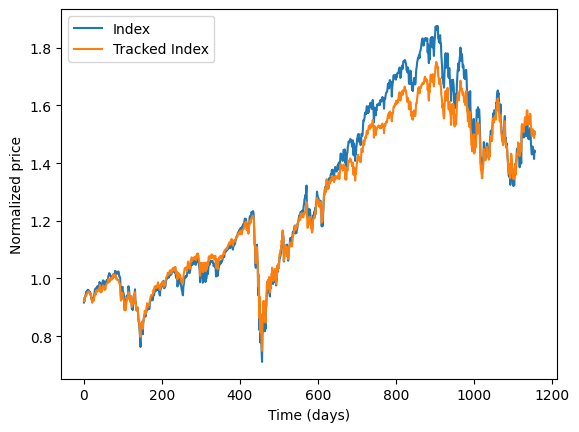

The grade for this assignment is 87.00, The number of stocks is 10
37/37 [==============================] - 0s 1ms/step


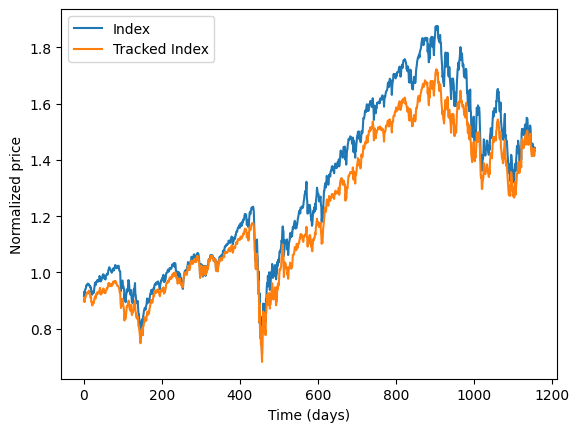

The grade for this assignment is 79.00, The number of stocks is 11
37/37 [==============================] - 0s 2ms/step


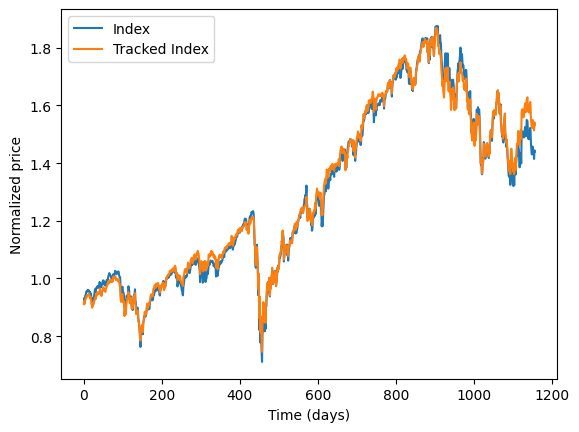

The grade for this assignment is 94.00, The number of stocks is 12
37/37 [==============================] - 0s 1ms/step


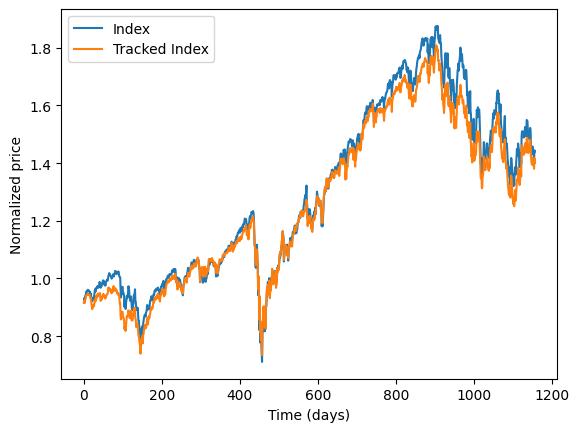

The grade for this assignment is 88.00, The number of stocks is 13
37/37 [==============================] - 0s 1ms/step


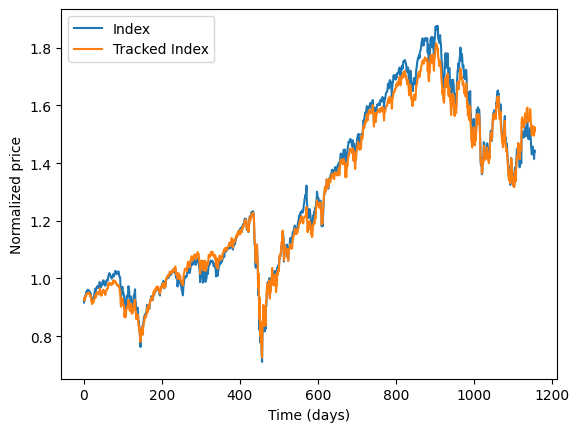

The grade for this assignment is 92.00, The number of stocks is 14
37/37 [==============================] - 0s 1ms/step


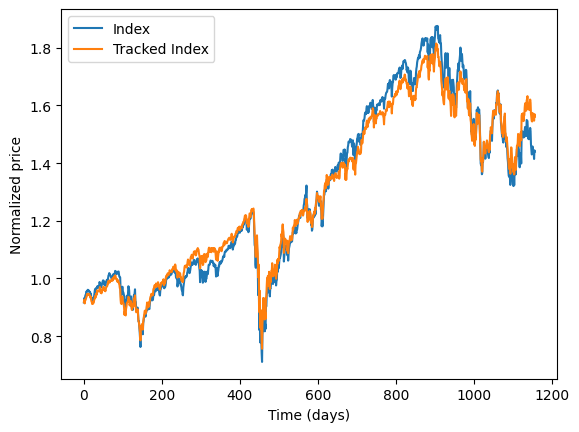

The grade for this assignment is 90.00, The number of stocks is 15
37/37 [==============================] - 0s 961us/step


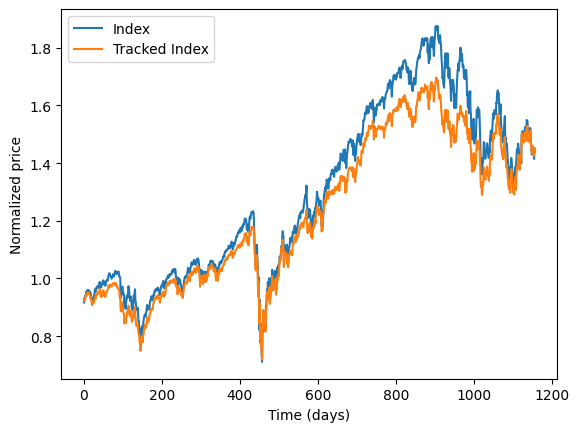

The grade for this assignment is 81.00, The number of stocks is 16
37/37 [==============================] - 0s 1ms/step


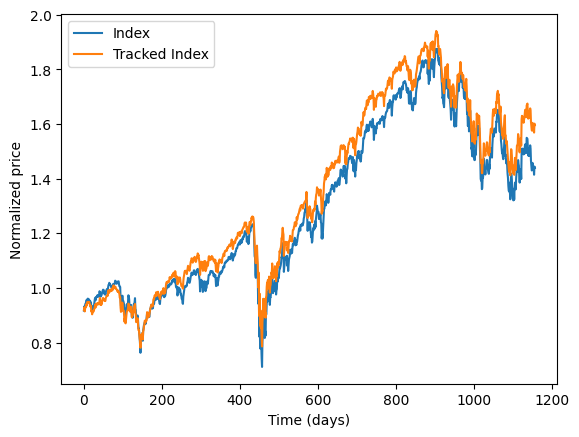

The grade for this assignment is 84.00, The number of stocks is 17
37/37 [==============================] - 0s 1ms/step


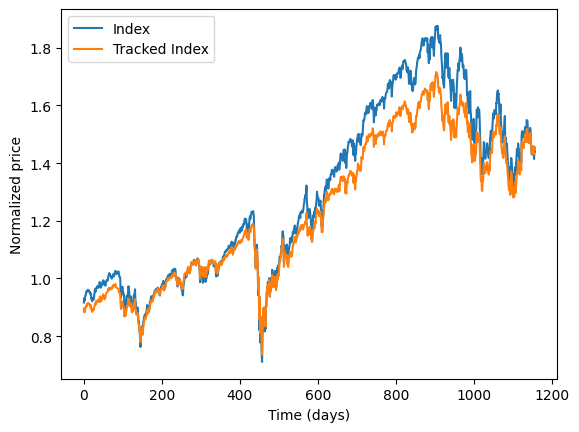

The grade for this assignment is 80.00, The number of stocks is 18
37/37 [==============================] - 0s 1ms/step


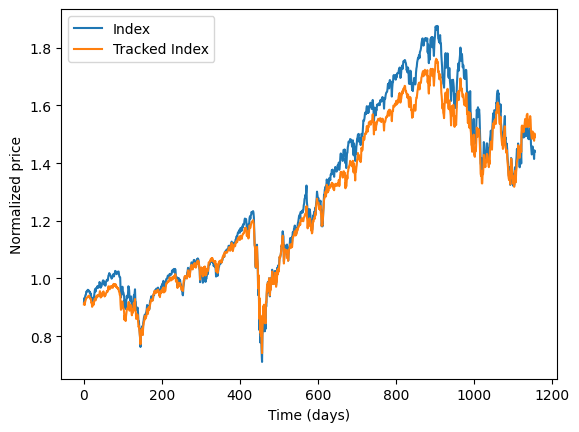

The grade for this assignment is 86.00, The number of stocks is 19
37/37 [==============================] - 0s 1ms/step


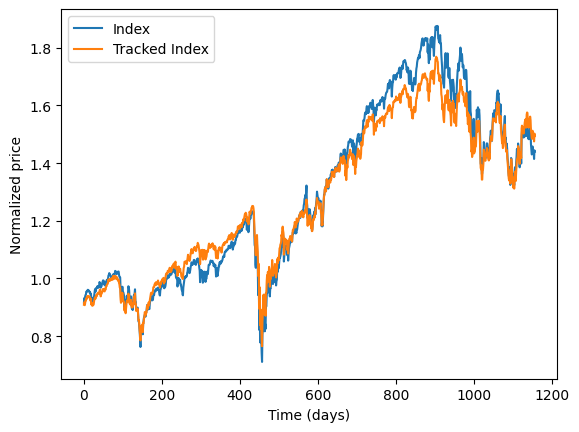

The grade for this assignment is 86.00, The number of stocks is 20
37/37 [==============================] - 0s 1ms/step


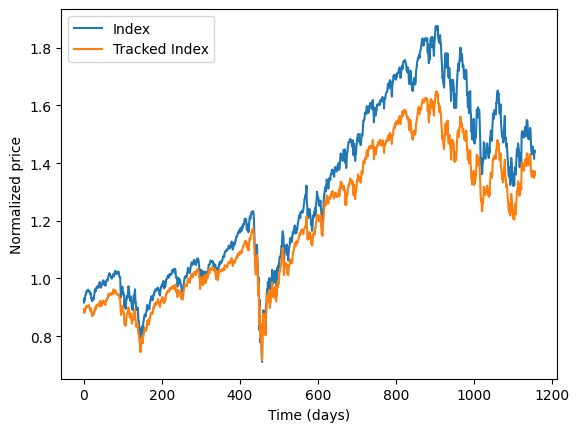

The grade for this assignment is 71.00, The number of stocks is 21
37/37 [==============================] - 0s 983us/step


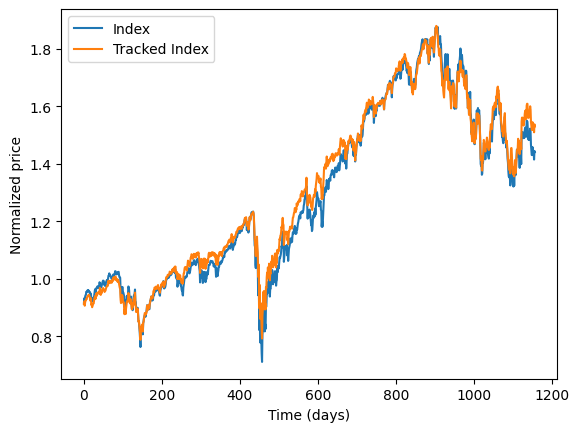

The grade for this assignment is 90.00, The number of stocks is 22
37/37 [==============================] - 0s 1ms/step


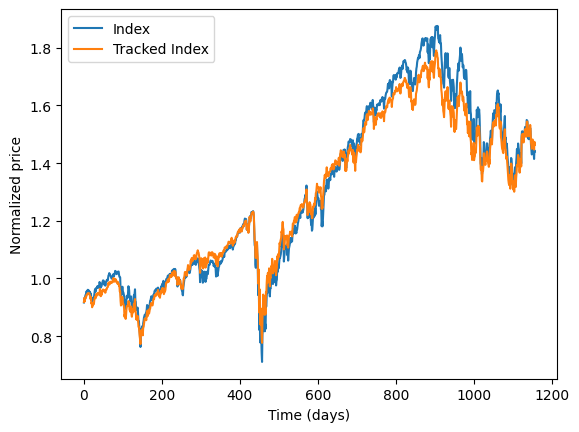

The grade for this assignment is 88.00, The number of stocks is 23
37/37 [==============================] - 0s 1ms/step


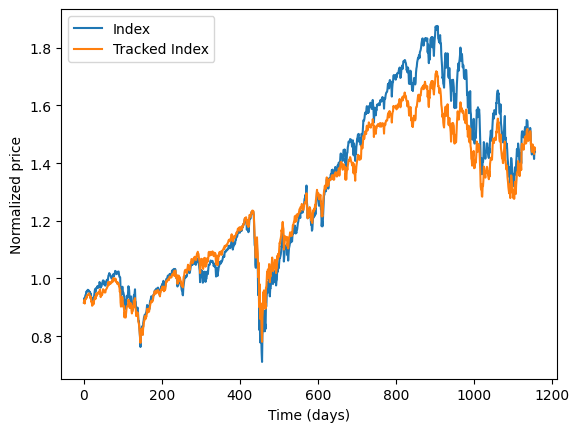

The grade for this assignment is 81.00, The number of stocks is 24
37/37 [==============================] - 0s 1ms/step


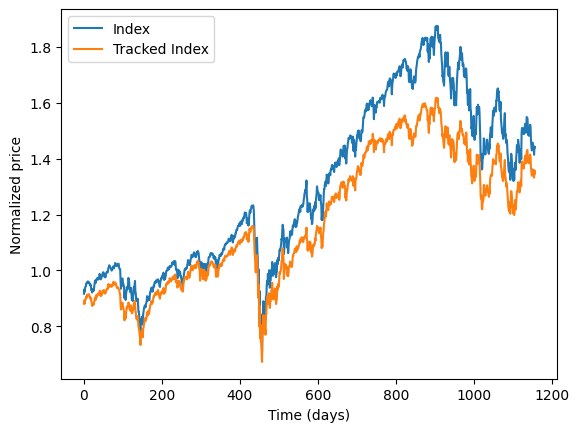

The grade for this assignment is 67.00, The number of stocks is 25
37/37 [==============================] - 0s 1ms/step


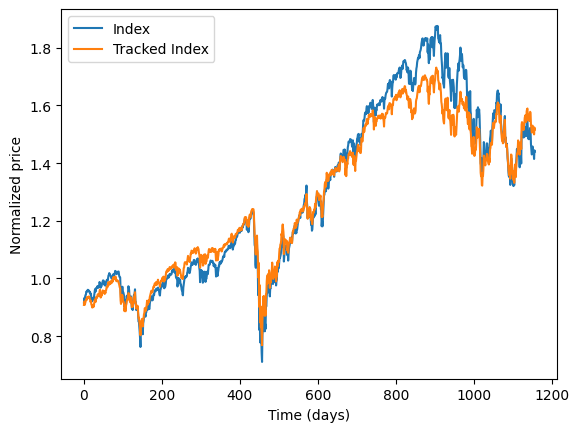

The grade for this assignment is 85.00, The number of stocks is 26
37/37 [==============================] - 0s 987us/step


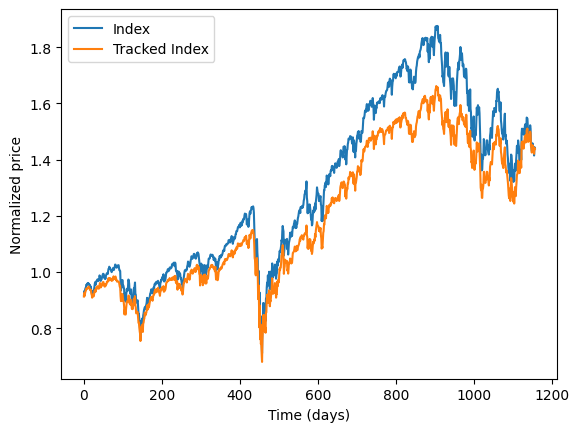

The grade for this assignment is 73.00, The number of stocks is 27
37/37 [==============================] - 0s 991us/step


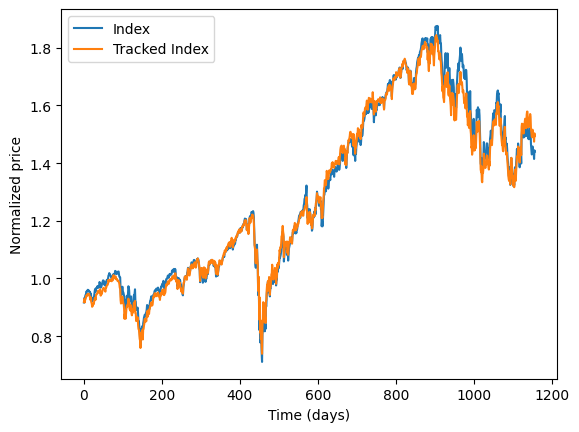

The grade for this assignment is 92.00, The number of stocks is 28
37/37 [==============================] - 0s 1ms/step


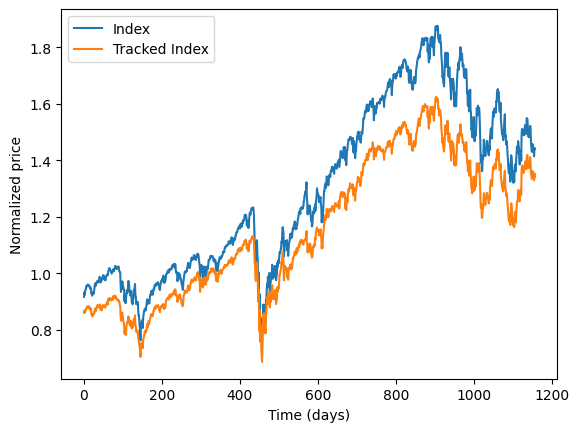

The grade for this assignment is 64.00, The number of stocks is 29
37/37 [==============================] - 0s 1ms/step


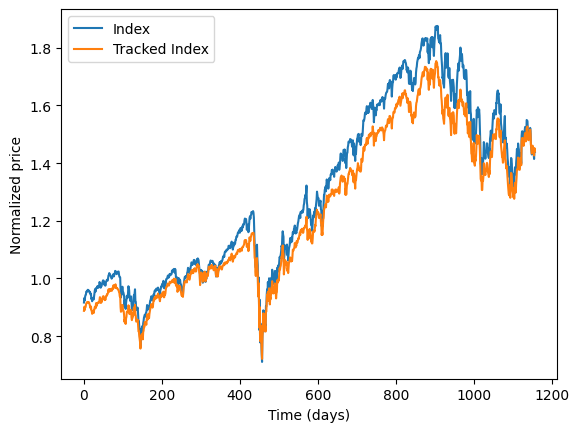

The grade for this assignment is 81.00, The number of stocks is 30
37/37 [==============================] - 0s 1ms/step


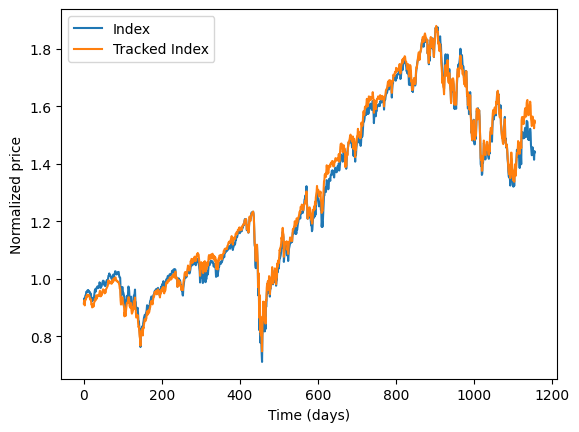

The grade for this assignment is 92.00, The number of stocks is 31
37/37 [==============================] - 0s 1ms/step


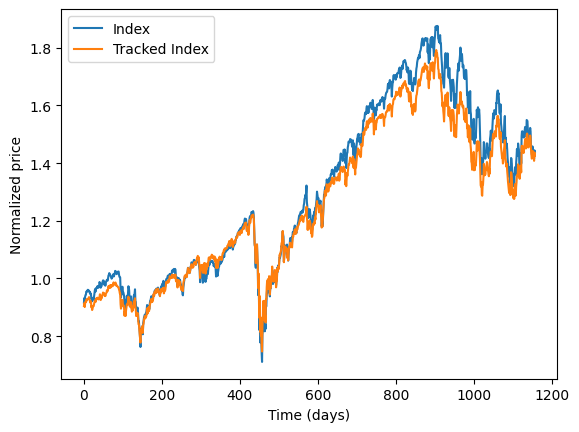

The grade for this assignment is 84.00, The number of stocks is 32
37/37 [==============================] - 0s 1ms/step


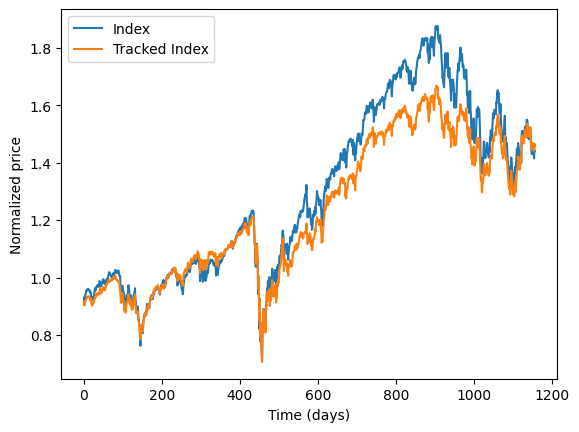

The grade for this assignment is 76.00, The number of stocks is 33
37/37 [==============================] - 0s 1ms/step


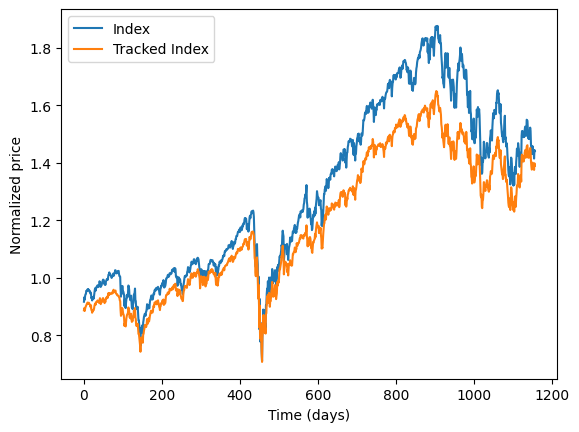

The grade for this assignment is 69.00, The number of stocks is 34
37/37 [==============================] - 0s 1ms/step


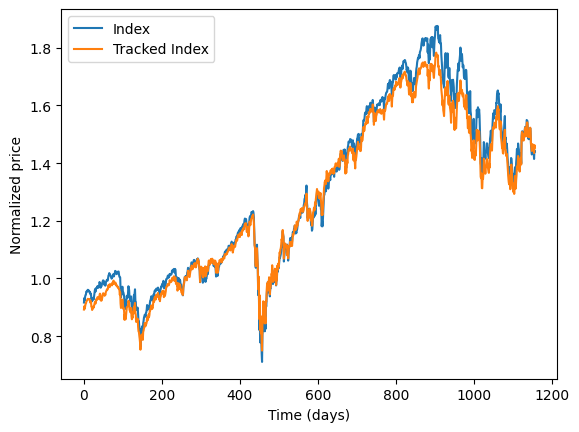

The grade for this assignment is 88.00, The number of stocks is 35
37/37 [==============================] - 0s 975us/step


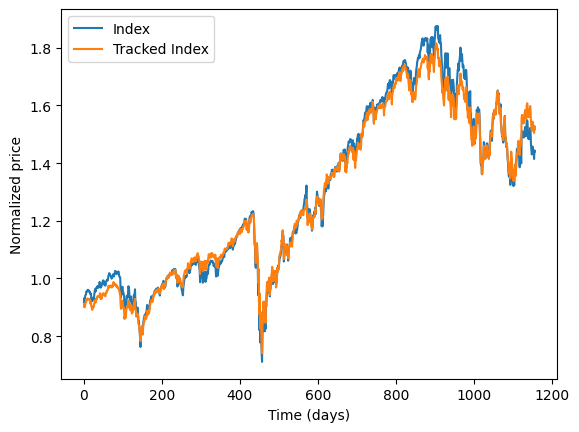

The grade for this assignment is 90.00, The number of stocks is 36
37/37 [==============================] - 0s 977us/step


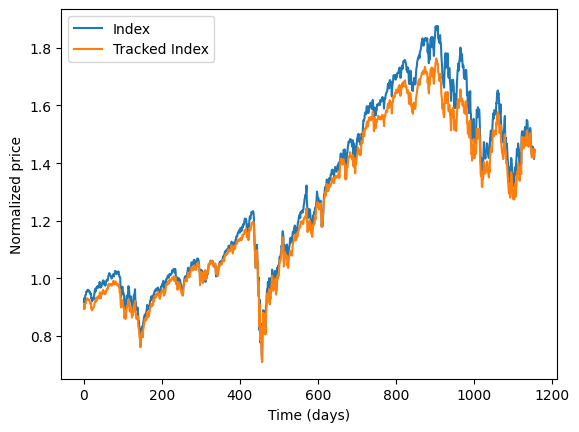

The grade for this assignment is 85.00, The number of stocks is 37
37/37 [==============================] - 0s 1ms/step


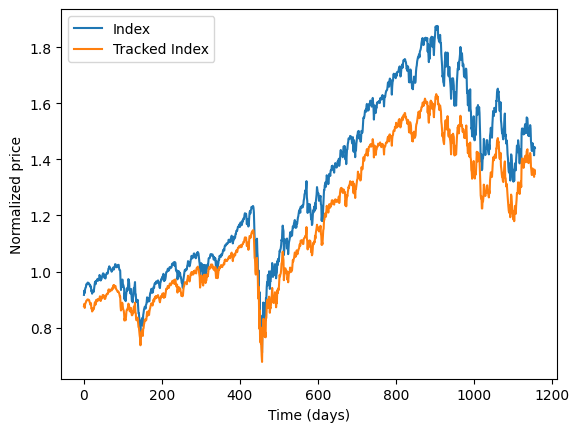

The grade for this assignment is 67.00, The number of stocks is 38
37/37 [==============================] - 0s 1ms/step


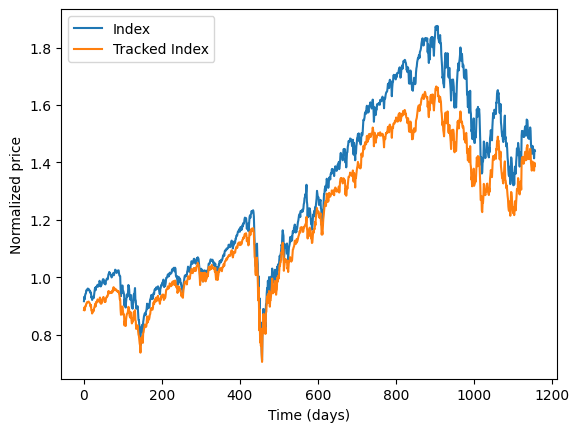

The grade for this assignment is 72.00, The number of stocks is 39
37/37 [==============================] - 0s 962us/step


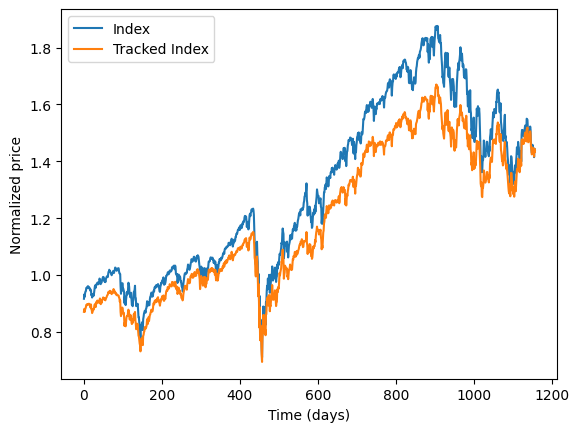

The grade for this assignment is 71.00, The number of stocks is 40
37/37 [==============================] - 0s 1ms/step


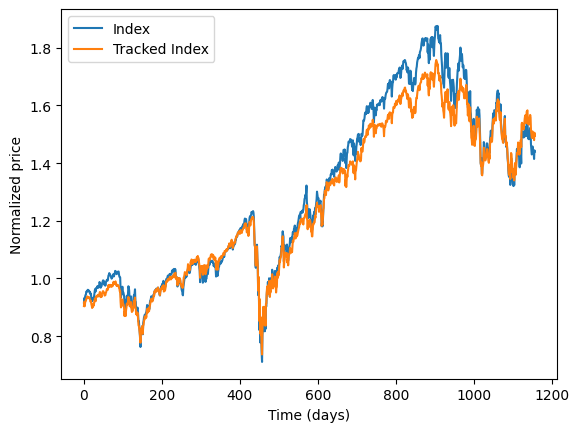

The grade for this assignment is 84.00, The number of stocks is 41
37/37 [==============================] - 0s 1ms/step


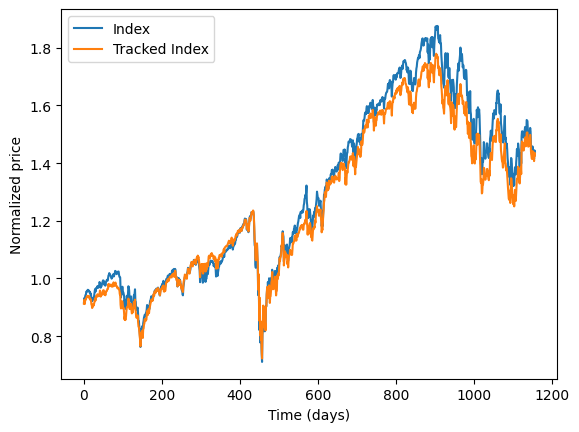

The grade for this assignment is 84.00, The number of stocks is 42
37/37 [==============================] - 0s 1ms/step


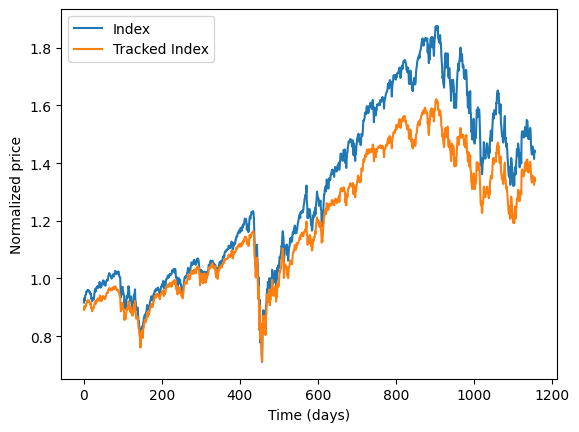

The grade for this assignment is 67.00, The number of stocks is 43
37/37 [==============================] - 0s 1ms/step


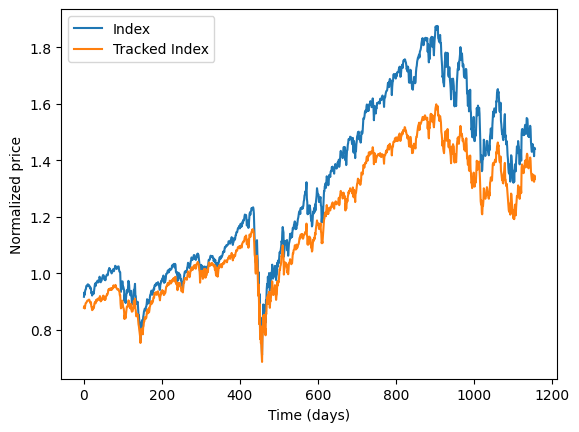

The grade for this assignment is 63.00, The number of stocks is 44
37/37 [==============================] - 0s 975us/step


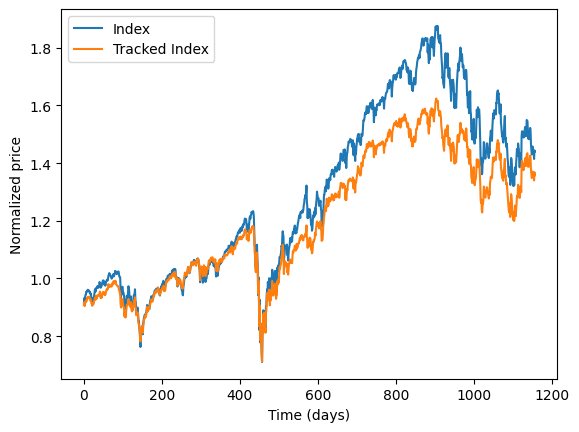

The grade for this assignment is 69.00, The number of stocks is 45


KeyboardInterrupt: 

In [12]:
#find the parameter that can produce the best grade
best_result = {'grade':-1,'n_stocks':-1,'index_test':np.array,'outsample_test':np.array}
for n in range(1,50,1):
    g,idx_test,idx_outsample = fine_tuning(X_train,X_test,index_test,10000,n)
    if g > best_result['grade']:
        best_result['grade'] = g
        best_result['n_stocks'] = n 
        best_result['index_test'] = idx_test
        best_result['outsample_test'] = idx_outsample
    print(f'The grade for this assignment is {math.ceil(g * 100):.2f}, The number of stocks is {n}')

In [13]:
#find the best result
index_test = best_result['index_test']
tracked_index_outofsample = best_result['outsample_test']

**Instructions to let the next code cell run:**

Before running the cell below, ensure the following:

- The target variable of your problem has to be named exactly `index_test`, while the out-of-sample prediction variable has to be named `tracked_index_outofsample`. Store the number of companies to reconstruct the index dynamic in a variable called `n`. The calculation of the evaluation function relies on this naming convention to determine the final grade. Please make sure that both `index_test` and `tracked_index_outofsample` are numpy arrays of dimensionality (1158,) where 1158 is the length of the out-of-sample set. If the dimensions are different than that the following cell will not run.

By adhering to these naming conventions, the grading cell can compute the final score without any issues.

In [14]:
import numpy as np
import math

def evaluate_index_performance(y_test, y_pred, num_companies_used, total_companies=360, weight_rmse=0.7, weight_efficiency=0.3):
    """
    Function to evaluate the performance of the reconstructed index.
    
    :param y_test: Actual index values (out of sample)
    :param y_pred: Predicted index values using a subset of companies
    :param num_companies_used: Number of companies used for the reconstruction
    :param total_companies: Total number of companies in the index (default 500 for S&P 500)
    :param weight_mse: Weight for the MSE score (default 0.7)
    :param weight_efficiency: Weight for the efficiency score (default 0.3)
    :return: A composite score combining MSE and efficiency
    """
    # Calculate MSE and normalized MSE score
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    max_possible_rmse = y_test.std()
    rmse_score = 1 - rmse / max_possible_rmse

    # Calculate efficiency score
    efficiency_score = 1 - (num_companies_used / total_companies)

    # Calculate final grade
    final_score = weight_rmse * rmse_score + weight_efficiency * efficiency_score

    return final_score

grade = evaluate_index_performance(index_test, tracked_index_outofsample, n)
print(f'The grade for this assignment is {math.ceil(grade * 100):.2f}')


The grade for this assignment is 91.00
